# Test for the cnn module

Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

The test consists of six model data sets.

## Distancematrix calculation

### Original implementation

In [1]:
def dist_baseline(data):
    dist = np.zeros((len(data), len(data)))

    for i in range(np.shape(data)[1]):
        (A,B) = np.meshgrid(data[:,i],data[:,i])
        dist += ((A-B)**2)
        
    return np.sqrt(dist)

### scipy.spatial.distance.cdist

In [2]:
def dist_cdist(data):
    return cdist(data, data)

## Clustering
#### (starting with precalculated distance matrix; no post processing)

### Original implementation

In [14]:
def ismember(a, b):
    bi = {}
    for i, el in enumerate(b):
        if el not in bi:
            bi[el] = i
    return [bi.get(itm, -1) for itm in a]

def fit_baseline(dist, radius_cutoff=0.15, cnn_cutoff=7, member_cutoff=1, max_clusters=None):
    rc = radius_cutoff
    nnnc = cnn_cutoff
    
    N=np.int_(np.shape(dist)[0])
    
    # Prepare neighborlist

    Numbi=np.zeros(N)
    distn=[0]*N

    # Calculate Neighborlist

    for i in range(N):

        Vec=np.nonzero(dist[i,:]<=rc)[0]
        Numbi[i]=len(Vec)
        distn[i]=Vec   

    # Preset parameters for the clustering

    cn=0                # Cluster Number
    w=0                 # Control value I
    Clust=[0]*N         # Preset Cluster List

    # Filter noise points

    Numbi[Numbi<nnnc]=0

    while w<1:    

        # Find maximal number of nearest neighbors

        Nmax=np.nonzero(Numbi==max(Numbi))[0]

        # Reset cluster

        C=np.zeros(N,dtype=int)                 

        # Write point with the highest density in the cluster

        C[0]=Nmax[0]

        # Cluster index

        cl=int(1)               

        # Control value II

        cc=1

        # Cluster index for new added points    

        lv=0                                    
        ci=np.zeros(N,dtype=int)      

        # Mask point with the highest density

        Numbi[Nmax[0]]=0  

        while cc>0:

            # Reset control value II and define new limits

            ci[lv]=cl                   
            cc=0           

            for a in C[ci[lv-1]:ci[lv]]:

                # Extract Neighborlist of a within rc

                Na=distn[a]

                # Compare Neighborlists of a and all reachable datapoints              

                for b in Na:

                    # Check if point is already clustered                  

                    if Numbi[b]>0:

                        Nb=distn[b]

                        tcc=np.asarray(ismember(Na,Nb))
                        tc=len(tcc[tcc>=0])

                        # Check if b in the Nearest Neighbors of a                    

                        if b in Na:
                            tb=1
                        else:
                            tb=0

                        # Check if a in the Nearest Neighbors of b

                        if a in Nb:
                            ta=1
                        else:
                            ta=0

                        # Check truncation criterion

                        if tc >= nnnc and ta > 0 and tb > 0:

                            # Add point to the cluster

                            C[cl]=b
                            cl=cl+1
                            cc=cc+1

                            # Mask clustered point

                            Numbi[b]=0

            # Update lv

            lv=lv+1                                             

        # Write Cluster to the Cluster List

        Cc=np.int_(C[:cl])                                    
        Clust[cn]=Cc
        cn=cn+1           

        # Truncation criteria 

        if sum(Numbi)==0:          # All particles are clustered
            w=2
        if cn==N:               # The maximal number of clusters is reached
            w=2
        
    return Clust

### v1

In [4]:
def fit_v1(dist, radius_cutoff=0.15, cnn_cutoff=5, member_cutoff=1, max_clusters=None):
    n_points = len(dist)
    # calculate neighbour list
    neighbours = np.asarray([
        np.where((x > 0) & (x <= radius_cutoff))[0]
        for x in dist
        ])
    n_neighbours = np.asarray([len(x) for x in neighbours])
    include = np.ones(len(neighbours), dtype=bool)
    include[np.where(n_neighbours < cnn_cutoff)[0]] = False

    _clusterdict = defaultdict(SortedList)
    _clusterdict[0].update(np.where(include == False)[0])
    _labels = np.zeros(n_points).astype(int)
    current = 1
    
    enough = False
    while any(include) and not enough:
        # find point with highest neighbour count
        point = np.where(
            (n_neighbours == np.max(n_neighbours[include]))
            & (include == True)
        )[0][0]
        _clusterdict[current].add(point)
        new_point_added = True
        _labels[point] = current
        include[point] = False
        # done = 0
        while new_point_added:
            new_point_added = False
            # for member in _clusterdict[current][done:]:
            for member in [
                added_point for added_point in _clusterdict[current]
                if any(include[neighbours[added_point]])
                ]:
                # Is the SortedList dangerous here?
                for neighbour in neighbours[member][include[neighbours[member]]]:
                    common_neighbours = (
                        set(neighbours[member])
                        & set(neighbours[neighbour])
                        )

                    if len(common_neighbours) >= cnn_cutoff:
                    # and (point in neighbours[neighbour])
                    # and (neighbour in neighbours[point]):
                        _clusterdict[current].add(neighbour)
                        new_point_added = True
                        _labels[neighbour] = current
                        include[neighbour] = False

            # done += 1   
        current += 1

        if max_clusters is not None:
            if current == max_clusters+1:
                enough = True

### v1 with times

In [5]:
def fit_v1t(dist, radius_cutoff=0.15, cnn_cutoff=5, member_cutoff=1, max_clusters=None):
    go = time.time()
    print("Function called")
    
    n_points = len(dist)
    # calculate neighbour list
    neighbours = np.asarray([
        np.where((x > 0) & (x <= radius_cutoff))[0]
        for x in dist
        ])
    n_neighbours = np.asarray([len(x) for x in neighbours])
    include = np.ones(len(neighbours), dtype=bool)
    include[np.where(n_neighbours < cnn_cutoff)[0]] = False

    _clusterdict = defaultdict(SortedList)
    _clusterdict[0].update(np.where(include == False)[0])
    _labels = np.zeros(n_points).astype(int)
    current = 1

    print(f"Initialisation done: {time.time() - go}")

    enough = False
    while any(include) and not enough:
        # find point with highest neighbour count
        point = np.where(
            (n_neighbours == np.max(n_neighbours[include]))
            & (include == True)
        )[0][0]
        _clusterdict[current].add(point)
        new_point_added = True
        _labels[point] = current
        include[point] = False
        print(f"Opened cluster {current}: {time.time() - go}")
        # done = 0
        while new_point_added:
            new_point_added = False
            # for member in _clusterdict[current][done:]:
            for member in [
                added_point for added_point in _clusterdict[current]
                if any(include[neighbours[added_point]])
                ]:
                # Is the SortedList dangerous here?
                for neighbour in neighbours[member][include[neighbours[member]]]:
                    common_neighbours = (
                        set(neighbours[member])
                        & set(neighbours[neighbour])
                        )

                    if len(common_neighbours) >= cnn_cutoff:
                    # and (point in neighbours[neighbour])
                    # and (neighbour in neighbours[point]):
                        _clusterdict[current].add(neighbour)
                        new_point_added = True
                        _labels[neighbour] = current
                        include[neighbour] = False

            # done += 1   
        current += 1

        if max_clusters is not None:
            if current == max_clusters+1:
                enough = True

    print(f"Clustering done: {time.time() - go}")

Other import:

In [6]:
import importlib
import cnn
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from itertools import cycle, islice
from collections import defaultdict
import time
from sortedcontainers import SortedList
from scipy.optimize import curve_fit
import tracemalloc
import os
import linecache

In [71]:
importlib.reload(cnn)

<module 'cnn' from '/home/janjoswig/CNN/cnn/cnn.py'>

In [7]:
from matplotlib import cm
from pylab import rcParams
rcParams['figure.figsize'] = 6.50128*0.5, 6.50128*0.5*0.618*1.1
dpi = 300
rcParams['figure.dpi'] =  dpi
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Latin Modern Sans'

In [63]:
color = ['#000000', '#396ab1', '#da7c30',
        '#3e9651', '#cc2529', '#535154',
        '#6b4c9a', '#922428', '#948b3d']

In [64]:
samples = [100, 500, 1000, 5000, 10000, 15000]

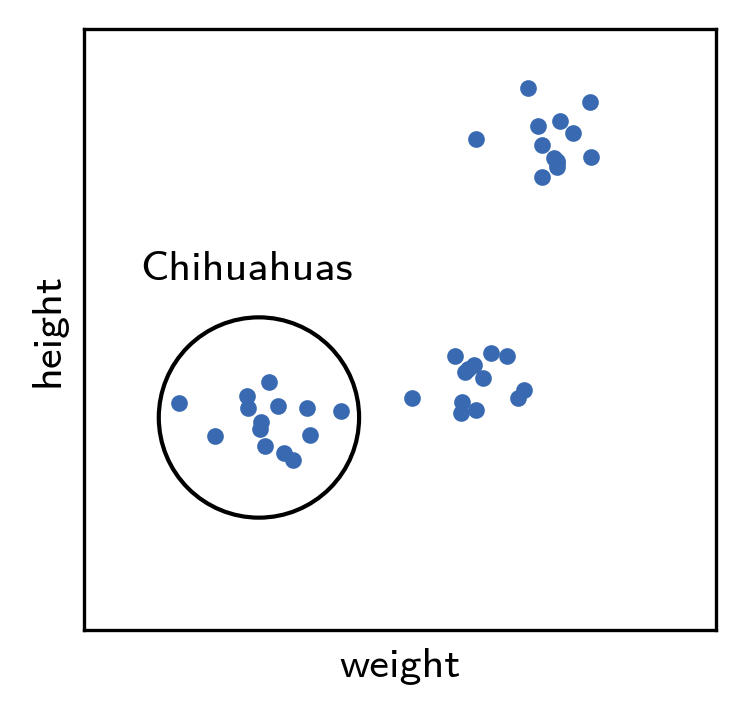

In [9]:
fig, ax = plt.subplots()
blobs, _ = datasets.make_blobs(
        centers = [[-4, -4], [3, -2], [5, 8]],
        n_samples=40,
        random_state=6
        )
blobs = StandardScaler().fit_transform(blobs)

circle = plt.Circle(
    (-1.35, -0.8),
    radius=0.8,
    edgecolor='black',
    facecolor='none')
ax.add_artist(circle)

ax.annotate(xy=(-2.3, 0.3), s='Chihuahuas')
ax.plot(
    blobs[:, 0],
    blobs[:, 1],
    '.')
ax.set(**{
    "xticks": (),
    "yticks": (),
    "xlim": (-2.75, 2.3),
    "ylim": (-2.5, 2.3),
    "aspect": 'equal',
    "ylabel": "height",
    "xlabel": "weight",
})

fig.tight_layout(pad=0.1)
fig.savefig("/home/janjoswig/Documents/Presentation/cnn/cluster_example_dogs.png")

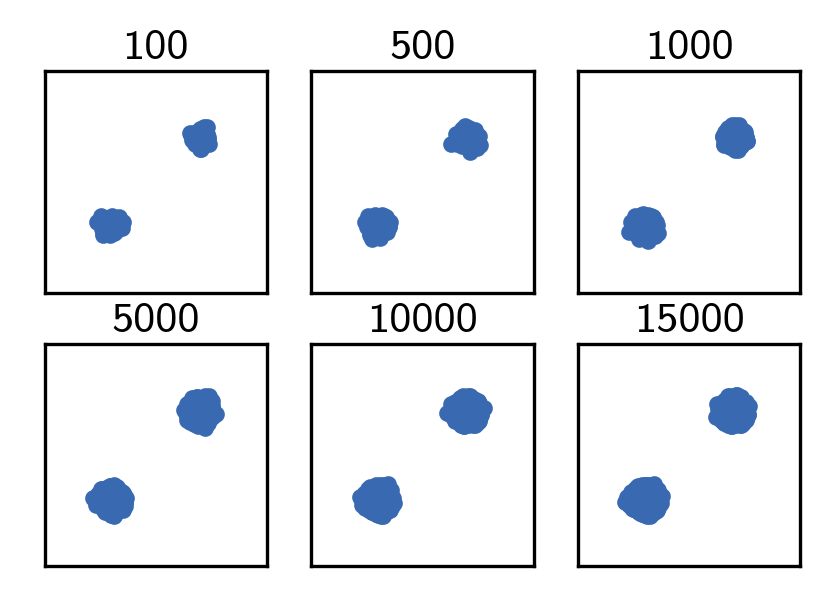

In [65]:
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()
for i, n in enumerate(samples):
    blobs, _ = datasets.make_blobs(
        centers = [[-10, -10], [10, 10]],
        n_samples=n,
        random_state=8
        )
    blobs = StandardScaler().fit_transform(blobs)

    Ax[i].plot(
        blobs[:, 0],
        blobs[:, 1],
        '.')
    Ax[i].set(**{
        "xticks": (),
        "yticks": (),
        "xlim": (-2.5, 2.5),
        "ylim": (-2.5, 2.5),
        "aspect": 'equal',
    })

    Ax[i].set_title(f"{n}", fontsize=10, pad=3)

In [15]:
params = {100: 
    {'radius_cutoff': 0.5,
     'cnn_cutoff': 0,
     'member_cutoff': 1,
     'max_clusters': None},
          500:
    {'radius_cutoff': 0.5,
     'cnn_cutoff': 0,
     'member_cutoff': 1,
     'max_clusters': None},
          1000:
    {'radius_cutoff': 0.5,
     'cnn_cutoff': 0,
     'member_cutoff': 1,
     'max_clusters': None},
          5000:
    {'radius_cutoff': 0.5,
     'cnn_cutoff': 0,
     'member_cutoff': 1,
     'max_clusters': None},
          10000:
    {'radius_cutoff': 0.5,
     'cnn_cutoff': 0,
     'member_cutoff': 1,
     'max_clusters': None},
          15000:
    {'radius_cutoff': 0.5,
     'cnn_cutoff': 0,
     'member_cutoff': 1,
     'max_clusters': None},}

In [62]:
params = {100: 
    {'radius_cutoff': 0.15,
     'cnn_cutoff': 5,
     'member_cutoff': 1,
     'max_clusters': None},
          500:
    {'radius_cutoff': 0.15,
     'cnn_cutoff': 5,
     'member_cutoff': 1,
     'max_clusters': None},
          1000:
    {'radius_cutoff': 0.15,
     'cnn_cutoff': 5,
     'member_cutoff': 1,
     'max_clusters': None},
          5000:
    {'radius_cutoff': 0.15,
     'cnn_cutoff': 5,
     'member_cutoff': 1,
     'max_clusters': None},
          10000:
    {'radius_cutoff': 0.15,
     'cnn_cutoff': 5,
     'member_cutoff': 1,
     'max_clusters': None},
          15000:
    {'radius_cutoff': 0.15,
     'cnn_cutoff': 5,
     'member_cutoff': 1,
     'max_clusters': None},
         }

Configuration file found in /home/janjoswig
Calculating nxn distance matrix for 100 points
Execution time for call of fit():     0 hours, 0 minutes, 0.0075 seconds
recording: ... 
points                  100
radius_cutoff          0.15
cnn_cutoff                5
member_cutoff             1
max_clusters           None
n_clusters                2
largest                0.45
noise                  0.13
time             0.00753808
dtype: object
Configuration file found in /home/janjoswig
Calculating nxn distance matrix for 500 points
Execution time for call of fit():     0 hours, 0 minutes, 0.0814 seconds
recording: ... 
points                 500
radius_cutoff         0.15
cnn_cutoff               5
member_cutoff            1
max_clusters          None
n_clusters               2
largest                0.5
noise                0.006
time             0.0813973
dtype: object
Configuration file found in /home/janjoswig
Calculating nxn distance matrix for 1000 points
Execution time for call o

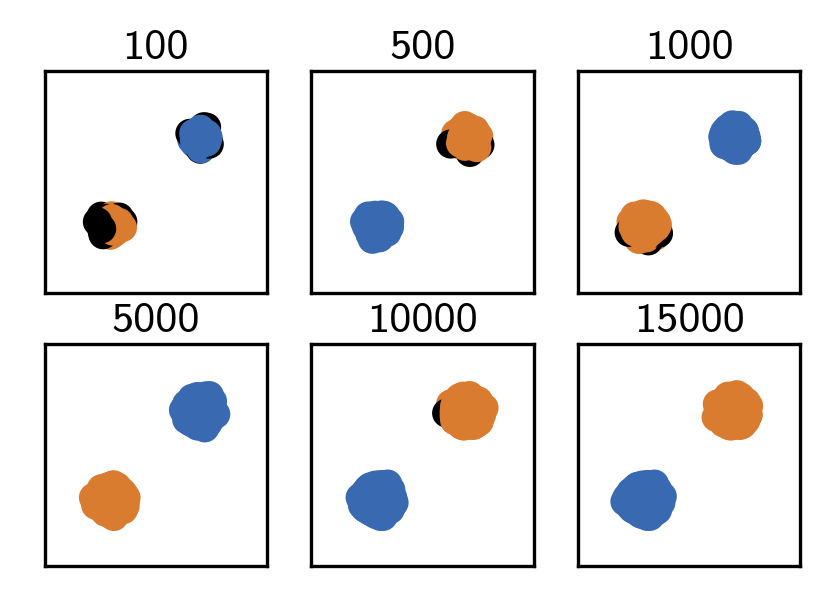

In [72]:
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()
for i, n in enumerate(samples):
    blobs, _ = datasets.make_blobs(
        centers = [[-10, -10], [10, 10]],
        n_samples=n,
        random_state=8
        )
    blobs = StandardScaler().fit_transform(blobs)

    cobj = cnn.CNN(train=blobs)

    cobj.fit(
        # rec=False,
        radius_cutoff=params[n]['radius_cutoff'],
        cnn_cutoff=params[n]['cnn_cutoff'],
        member_cutoff=params[n]['member_cutoff'],
        max_clusters=params[n]['max_clusters'],
        )
    
    colors = np.array(
    list(islice(cycle(
        color
            ), int(max(cobj.train_labels) + 1)       
        ))
    )
    
    Ax[i].scatter(
        cobj.train[0][:, 0],
        cobj.train[0][:, 1],
        c=colors[cobj.train_labels])
    Ax[i].set(**{
        "xticks": (),
        "yticks": (),
        "xlim": (-2.5, 2.5),
        "ylim": (-2.5, 2.5),
        "aspect": 'equal',
    })

    Ax[i].set_title(f"{n}", fontsize=10, pad=3)

Configuration file found in /home/janjoswig
Calculating nxn distance matrix for 100 points
Execution time for call of fit():     0 hours, 0 minutes, 0.0039 seconds
recording: ... 
points                  100
radius_cutoff           0.5
cnn_cutoff                0
member_cutoff             1
max_clusters           None
n_clusters                2
largest                 0.5
noise                     0
time             0.00390315
dtype: object
Configuration file found in /home/janjoswig
Calculating nxn distance matrix for 500 points
Execution time for call of fit():     0 hours, 0 minutes, 0.1039 seconds
recording: ... 
points               500
radius_cutoff        0.5
cnn_cutoff             0
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             0.10389
dtype: object
Configuration file found in /home/janjoswig
Calculating nxn distance matrix for 1000 points
Execution time for call of fit():     0 hou

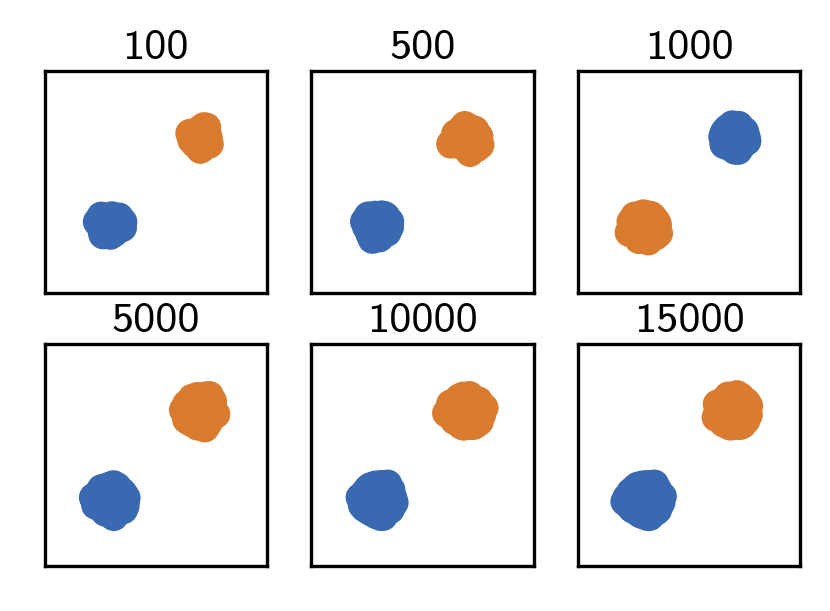

In [74]:
fig, ax = plt.subplots(2, 3)
Ax = ax.flatten()
for i, n in enumerate(samples):
    blobs, _ = datasets.make_blobs(
        centers = [[-10, -10], [10, 10]],
        n_samples=n,
        random_state=8
        )
    blobs = StandardScaler().fit_transform(blobs)

    cobj = cnn.CNN(train=blobs)

    cobj.fit(
        # rec=False,
        radius_cutoff=params[n]['radius_cutoff'],
        cnn_cutoff=params[n]['cnn_cutoff'],
        member_cutoff=params[n]['member_cutoff'],
        max_clusters=params[n]['max_clusters'],
        )
    
    colors = np.array(
    list(islice(cycle(
        color
            ), int(max(cobj.train_labels) + 1)       
        ))
    )
    
    Ax[i].scatter(
        cobj.train[0][:, 0],
        cobj.train[0][:, 1],
        c=colors[cobj.train_labels])
    Ax[i].set(**{
        "xticks": (),
        "yticks": (),
        "xlim": (-2.5, 2.5),
        "ylim": (-2.5, 2.5),
        "aspect": 'equal',
    })

    Ax[i].set_title(f"{n}", fontsize=10, pad=3)

In [11]:
def genblobs(n):
    blobs, _ = datasets.make_blobs(
        centers=[[-10, -10], [10, 10]],
        n_samples=n,
        random_state=8
    )
    return StandardScaler().fit_transform(blobs)

In [12]:
def bm_dist(generator, calculator, samples=None, runs=2):
    times = defaultdict(list)
    if samples is None:
        samples = [100, 500]
    elif not isinstance(samples, list):
        if not isinstance(samples, np.ndarray):
            samples = [samples]
        
    for i, n in enumerate(samples):
        data = generator(n)
        
        for run in range(runs):
            # tracemalloc.start()
            print(f"Run {1+run:3} on n = {n:5}", end="\r")
            go = time.time()
            calculator(data)       
            stop = time.time()
            stop = stop - go
            
            # snapshot = tracemalloc.take_snapshot()
            #display_top(snapshot)
            
            times[n].append(stop)
    
    return times, {n: (np.mean(s), np.std(s)) for n, s in times.items()}

In [22]:
def bm_fit(generator, calculator, samples=None, runs=2, params=None):
    times = defaultdict(list)
    if samples is None:
        samples = [100, 500]
    elif not isinstance(samples, list):
        if not isinstance(samples, np.ndarray):
            samples = [samples]
        
    for i, n in enumerate(samples):
        data = generator(n)
        dist = dist_cdist(data)
        
        
        p = {}
        if params is not None:
            try:
                p.update(params[n])
            except KeyError:
                pass
        
        # tracemalloc.start()
        for run in range(runs):
            print(f"Run {1+run:3} on n = {n:5}", end="\r")
            go = time.time()
            calculator(dist, **p)       
            stop = time.time()
            stop = stop - go
            
            times[n].append(stop)
            
        # snapshot = tracemalloc.take_snapshot()
        # display_top(snapshot)            
    
    return times, {n: (np.mean(s), np.std(s)) for n, s in times.items()}

In [17]:
def display_top(snapshot, key_type='lineno', limit=3):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        # replace "/path/to/module/file.py" with "module/file.py"
        filename = os.sep.join(frame.filename.split(os.sep)[-2:])
        print("#%s: %s:%s: %.1f KiB"
              % (index, filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))

In [11]:
def scaling(n, t):
    return np.log(t[1:] / t[:-1]) / np.log(n[1:] / n[:-1])

### Fit for empirical growth function:

$ t = a n^b + c$

In [13]:
def scale(x, y, newx):
    def growth(n, a, b):
        return a*np.power(n, b)
    
    try:
        popt, pcov = curve_fit(growth, x, y, p0=(0, 2))
        perr = np.sqrt(np.diag(pcov))
        print(popt, perr)
        # return growth(newx, *popt), (popt[1], perr[1])
        return growth(newx, *popt), (popt[1], perr[1])
    except RuntimeError as error:
        print(error)

##  BM distance matrix

#### linear plot

In [13]:
av_dist_baseline = {}

In [31]:
np.save('av_dist_baseline.npy', av_dist_baseline)

In [19]:
samples = np.array(
    [50, 100, 200, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000, 4000, 5000, 7500, 10000, 12500, 15000]
)
runs=3

# baseline
_, av = bm_dist(genblobs, dist_baseline, samples=samples, runs=runs)
av_dist_baseline.update(av)
means_dist_baseline = np.array([v[0] for v in av_dist_baseline.values()])
stds_dist_baseline = np.array([v[1] for v in av_dist_baseline.values()])

newx = np.linspace(samples[0], samples[-1])
try:
    fity_dist_baseline, b_dist_baseline = scale(samples, means_dist_baseline, newx)
except TypeError:
    b_dist_baseline = (0., 0.)

[7.85222207e-08 1.91826756e+00] [1.40103725e-08 1.88291620e-02]


In [15]:
av_dist_cdist = {}

In [32]:
np.save('av_dist_cdist.npy', av_dist_cdist)

In [20]:
# cdist
_, av = bm_dist(genblobs, dist_cdist, samples=samples, runs=runs)
av_dist_cdist.update(av)
means_dist_cdist = np.array([v[0] for v in av_dist_cdist.values()])
stds_dist_cdist = np.array([v[1] for v in av_dist_cdist.values()])

newx = np.linspace(samples[0], samples[-1])
try:
    fity_dist_cdist, b_dist_cdist = scale(samples, means_dist_cdist, newx)
except TypeError:
    b_dist_cdist = (0., 0.)

[1.37875744e-08 1.90434582e+00] [2.59882913e-09 1.98947191e-02]


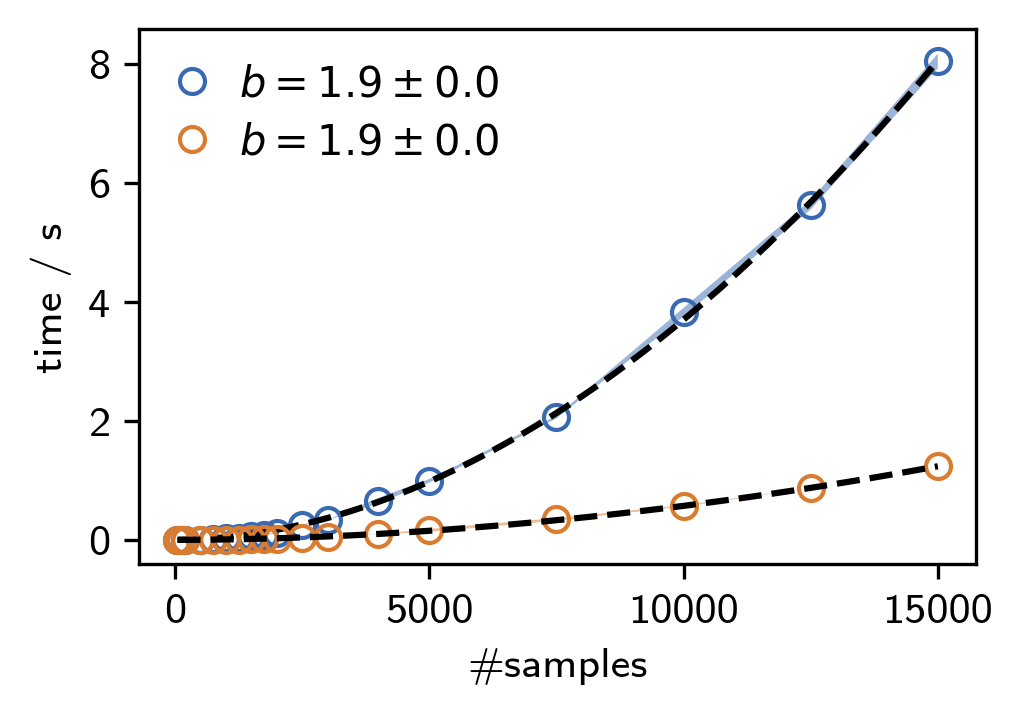

In [21]:
fig, ax = plt.subplots()

baseline, = ax.plot(samples, means_dist_baseline, 'o', markerfacecolor='none')
ax.fill_between(
    samples,
    means_dist_baseline - stds_dist_baseline,
    means_dist_baseline + stds_dist_baseline,
    alpha=0.5,
    edgecolor='none',
)
ax.plot(newx, fity_dist_baseline, 'k--')
    

improvedline, = ax.plot(samples, means_dist_cdist, 'o', markerfacecolor='none')
ax.fill_between(
    samples,
    means_dist_cdist - stds_dist_cdist,
    means_dist_cdist + stds_dist_cdist,
    alpha=0.5,
    edgecolor='none',
)

ax.plot(newx, fity_dist_cdist, 'k--')

ax.legend(
    (baseline, improvedline),
    [f'$b = {b_dist_baseline[0]:.1f} \pm {b_dist_baseline[1]:.1f}$',
     f'$b = {b_dist_cdist[0]:.1f} \pm {b_dist_cdist[1]:.1f}$'],
    frameon=False, handlelength=0.7)

ax.set(**{
    'xlabel': '#samples',
    'ylabel': 'time / s',
})

fig.tight_layout(pad=0.1)
fig.savefig('BM_dist_linear.png')

# logarithmic plot

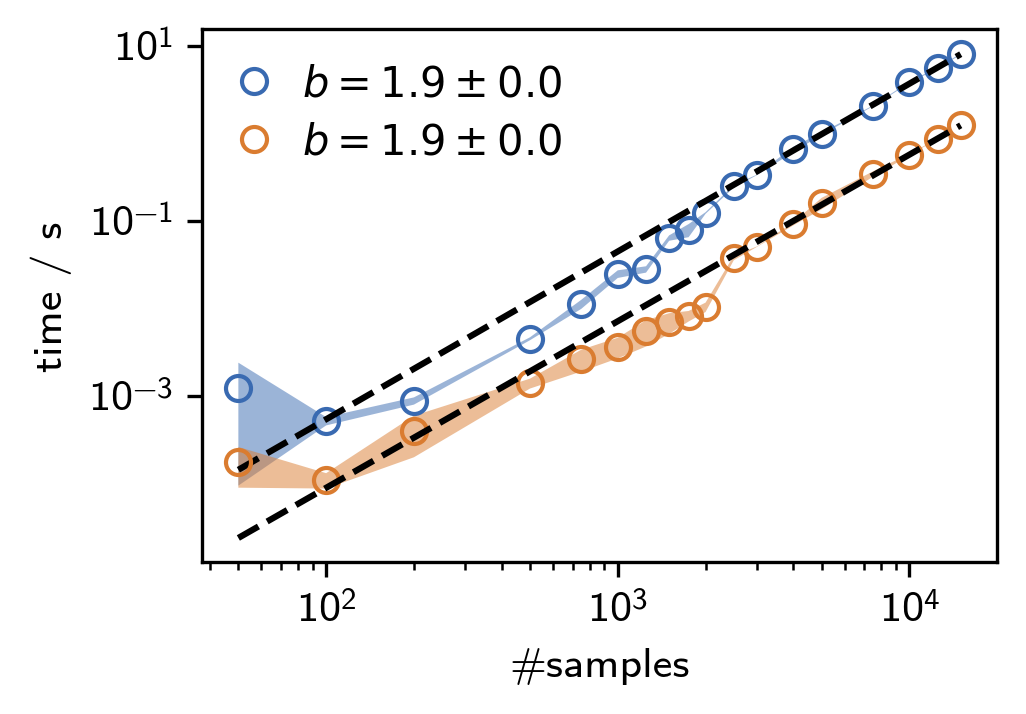

In [22]:
fig, ax = plt.subplots()

baseline, = ax.plot(samples, means_dist_baseline, 'o', markerfacecolor='none')
ax.fill_between(
    samples,
    means_dist_baseline - stds_dist_baseline,
    means_dist_baseline + stds_dist_baseline,
    alpha=0.5,
    edgecolor='none',
)
ax.plot(newx, fity_dist_baseline, 'k--')
    

improvedline, = ax.plot(samples, means_dist_cdist, 'o', markerfacecolor='none')
ax.fill_between(
    samples,
    means_dist_cdist - stds_dist_cdist,
    means_dist_cdist + stds_dist_cdist,
    alpha=0.5,
    edgecolor='none',
)

ax.plot(newx, fity_dist_cdist, 'k--')

ax.legend(
    (baseline, improvedline),
    [f'$b = {b_dist_baseline[0]:.1f} \pm {b_dist_baseline[1]:.1f}$',
     f'$b = {b_dist_cdist[0]:.1f} \pm {b_dist_cdist[1]:.1f}$'],
    frameon=False, handlelength=0.7)

ax.set(**{
    'xlabel': '#samples',
    'ylabel': 'time / s',
    'xscale': 'log',
    'yscale': 'log',
})

fig.tight_layout(pad=0.1)
fig.savefig('BM_dist_log.png')

## BM Fit
### linear plot

In [76]:
samples = np.array(
    [50, 100, 200, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000, 4000, 5000, 7500, 10000, 12500, 15000]
)
runs=6

In [16]:
samples = np.array(
    [50]
)
runs=1

In [17]:
av_fit_baseline = {}

In [18]:
pwd

'/home/janjoswig/CNN/tests/benchmarks'

In [79]:
np.save('T460/2/av_fit_baseline.npy', av_fit_baseline)

In [23]:
# baseline
paramslegacy = {}
paramslegacy.update(params)
for sample in paramslegacy:
    try:
        paramslegacy[sample]['cnn_cutoff'] += 2
    except KeyError:
        pass
        
_, av = bm_fit(genblobs, fit_baseline, samples=samples, runs=runs, params=paramslegacy)
av_fit_baseline.update(av)
means_fit_baseline = np.array([v[0] for v in av_fit_baseline.values()])
stds_fit_baseline = np.array([v[1] for v in av_fit_baseline.values()])

newx = np.linspace(samples[0], samples[-1])
try:
    fity_fit_baseline, b_fit_baseline = scale(samples, means_fit_baseline, newx)
except TypeError:
    b_fit_baseline = (0., 0.)

In [24]:
av_fit_v1 = {}

In [80]:
np.save('benchmarks/T460/2/av_fit_v1.npy', av_fit_v1)

In [25]:
# v1
_, av = bm_fit(genblobs, fit_v1, samples=samples, runs=runs, params=params)
av_fit_v1.update(av)
means_fit_v1 = np.array([v[0] for v in av_fit_v1.values()])
stds_fit_v1 = np.array([v[1] for v in av_fit_v1.values()])

# newx = np.linspace(samples[0], samples[-1])
try:
    fity_fit_v1, b_fit_v1 = scale(samples, means_fit_v1, newx)
except TypeError:
    b_fit_v1 = (0., 0.)

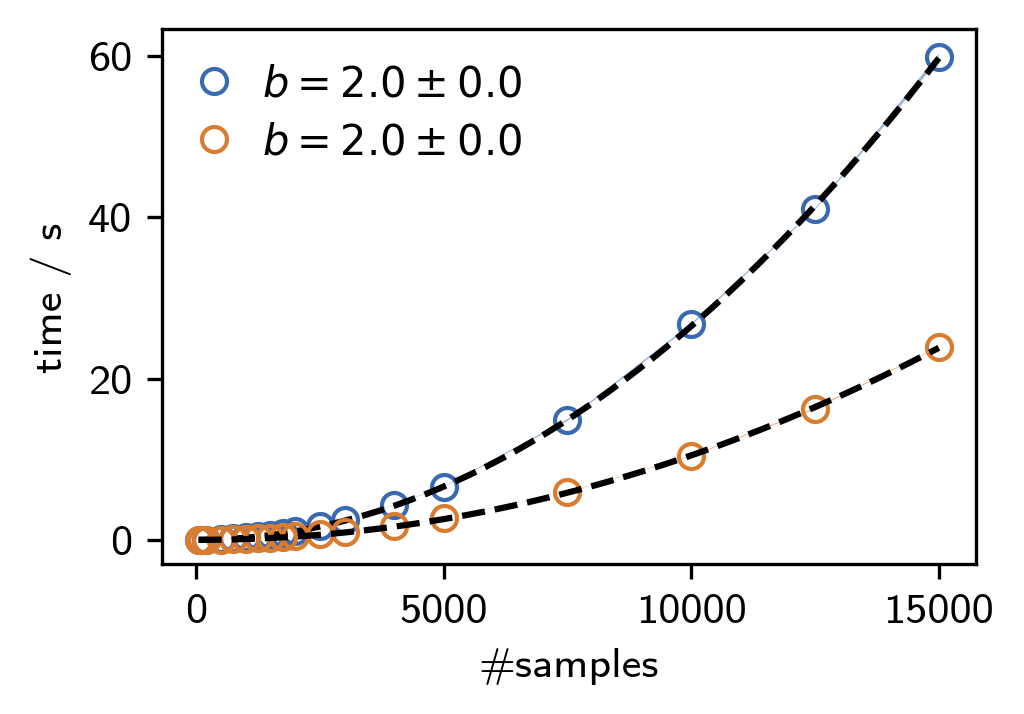

In [60]:
fig, ax = plt.subplots()

baseline, = ax.plot(samples, means_fit_baseline, 'o', markerfacecolor='none')
ax.fill_between(
    samples,
    means_fit_baseline - stds_fit_baseline,
    means_fit_baseline + stds_fit_baseline,
    alpha=0.5,
    edgecolor='none',
)
ax.plot(newx, fity_fit_baseline, 'k--')
    

improvedline, = ax.plot(samples, means_fit_v1, 'o', markerfacecolor='none')
ax.fill_between(
    samples,
    means_fit_v1 - stds_fit_v1,
    means_fit_v1 + stds_fit_v1,
    alpha=0.5,
    edgecolor='none',
)

ax.plot(newx, fity_fit_v1, 'k--')

ax.legend(
    (baseline, improvedline),
    [f'$b = {b_fit_baseline[0]:.1f} \pm {b_fit_baseline[1]:.1f}$',
     f'$b = {b_fit_v1[0]:.1f} \pm {b_fit_v1[1]:.1f}$'],
    frameon=False, handlelength=0.7)

ax.set(**{
    'xlabel': '#samples',
    'ylabel': 'time / s',
})

fig.tight_layout(pad=0.1)
fig.savefig('BM_fit_linear_2.png')

### logarithmic plot

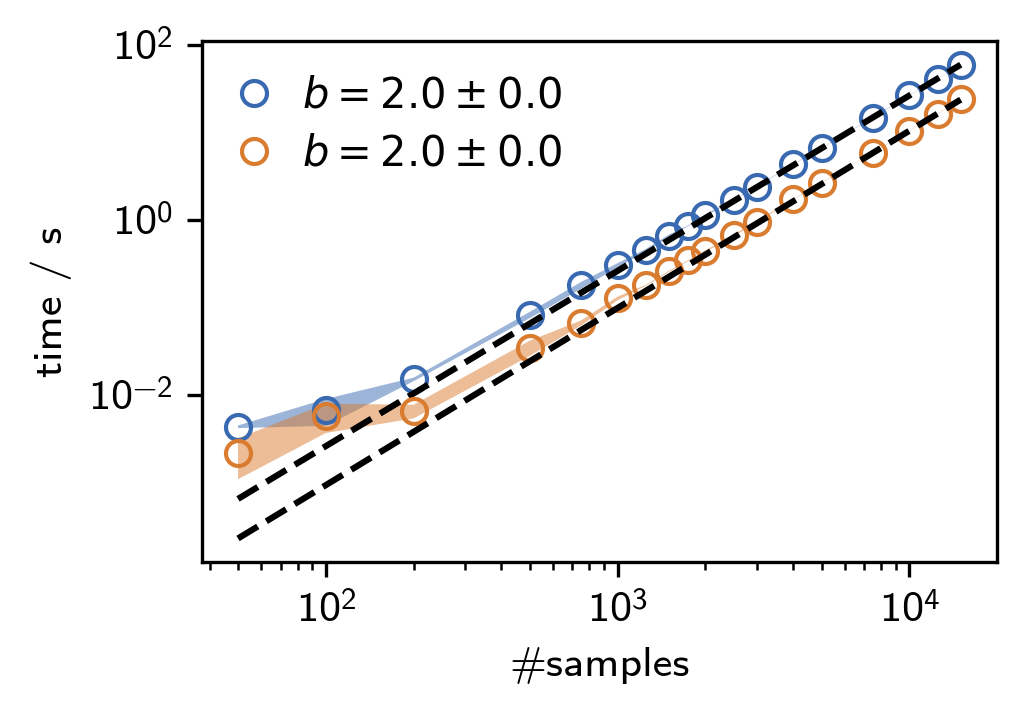

In [77]:
fig, ax = plt.subplots()

baseline, = ax.plot(samples, means_fit_baseline, 'o', markerfacecolor='none')
ax.fill_between(
    samples,
    means_fit_baseline - stds_fit_baseline,
    means_fit_baseline + stds_fit_baseline,
    alpha=0.5,
    edgecolor='none',
)
ax.plot(newx, fity_fit_baseline, 'k--')
    

improvedline, = ax.plot(samples, means_fit_v1, 'o', markerfacecolor='none')
ax.fill_between(
    samples,
    means_fit_v1 - stds_fit_v1,
    means_fit_v1 + stds_fit_v1,
    alpha=0.5,
    edgecolor='none',
)

ax.plot(newx, fity_fit_v1, 'k--')

ax.legend(
    (baseline, improvedline),
    [f'$b = {b_fit_baseline[0]:.1f} \pm {b_fit_baseline[1]:.1f}$',
     f'$b = {b_fit_v1[0]:.1f} \pm {b_fit_v1[1]:.1f}$'],
    frameon=False, handlelength=0.7)

ax.set(**{
    'xlabel': '#samples',
    'ylabel': 'time / s',
    'xscale': 'log',
    'yscale': 'log',
})

fig.tight_layout(pad=0.1)
# fig.savefig('BM_fit_log_2.png')

# Check sanity of fit_baseline(dist)

In [93]:
blobs = genblobs(1000)
dist = dist_cdist(blobs)
clust = fit_baseline(dist)

1000


In [95]:
np.shape(clust[0])

(500,)

In [96]:
Cs=np.zeros((2, 1000))
for a in range(0, 1000):
    Ca = clust[a]
    if np.int_(np.shape(Ca)) > 1:
        Cs[0,a]=np.int_(np.shape(Ca))
        Cs[1,a]=a

/home/janjoswig/.virtualenvs/CNN-5gkgQAOT/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  after removing the cwd from sys.path.


In [97]:
Cs

array([[500., 500.,   0., ...,   0.,   0.,   0.],
       [  0.,   1.,   0., ...,   0.,   0.,   0.]])

# Time of function parts

In [15]:
cobj = cnn.CNN(train=genblobs(5000))
cobj.fit(
    radius_cutoff=0.5, cnn_cutoff=0
)

Configuration file found in /home/janjoswig
Function called
Calculating nxn distance matrix for 5000 points
Data checked: 0.14256501197814941
Initialisation done: 0.34114813804626465
Opened cluster 1: 0.341717004776001
Opened cluster 2: 2.547671318054199
Clustering done: 4.874916076660156
Make clusters_no_noise copy: 4.875311613082886
Declared small clusters as noise: 4.875995874404907
Found largest cluster: 4.876129865646362
Updated state: 4.878902196884155
Returning: 4.878941059112549
Execution time for call of fit():     0 hours, 0 minutes, 4.8820 seconds
recording: ... 
points              5000
radius_cutoff        0.5
cnn_cutoff             0
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.88204
dtype: object


In [16]:
data = genblobs(5000)
dist = dist_cdist(data)
fit_v1t(dist)

Function called
Initialisation done: 0.18991732597351074
Opened cluster 1: 0.1903517246246338
Opened cluster 2: 2.38203501701355
Clustering done: 4.517738342285156


In [43]:
cobj = cnn.CNN(train=genblobs(10000))
cobj.fit(
    radius_cutoff=0.5, cnn_cutoff=0
)

Function called
Data checked: 0.0005562305450439453
Initialisation done: 0.7089548110961914
Opened cluster 1: 0.7095112800598145
Opened cluster 2: 10.931055307388306
Clustering done: 21.181684732437134
Make clusters_no_noise copy: 21.181809425354004
Declared small clusters as noise: 21.183122158050537
Found largest cluster: 21.18324065208435
Updated state: 21.188701629638672
Returning: 21.188765048980713
Execution time for call of fit():     0 hours, 0 minutes, 21.1947 seconds
recording: ... 
points             10000
radius_cutoff        0.5
cnn_cutoff             0
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             21.1947
dtype: object


In [11]:
data = genblobs(10000)
dist = dist_cdist(data)
fit_v1t(dist)

Function called
Initialisation done: 0.6801173686981201
Opened cluster 1: 0.6807167530059814
Opened cluster 2: 10.124916791915894
Clustering done: 19.749144077301025


In [44]:
cobj = cnn.CNN(train=genblobs(15000))
cobj.fit(
    radius_cutoff=0.5, cnn_cutoff=0
)

Configuration file found in /home/janjoswig
Function called
Calculating nxn distance matrix for 15000 points
Data checked: 1.1780126094818115
Initialisation done: 2.7671589851379395
Opened cluster 1: 2.7677252292633057
Opened cluster 2: 25.897799253463745
Clustering done: 49.609132528305054
Make clusters_no_noise copy: 49.60925102233887
Declared small clusters as noise: 49.61123824119568
Found largest cluster: 49.61133289337158
Updated state: 49.619022607803345
Returning: 49.61909818649292
Execution time for call of fit():     0 hours, 0 minutes, 49.6280 seconds
recording: ... 
points            15000
radius_cutoff       0.5
cnn_cutoff            0
member_cutoff         1
max_clusters       None
n_clusters            2
largest             0.5
noise                 0
time             49.628
dtype: object


In [10]:
data = genblobs(15000)
dist = dist_cdist(data)
fit_v1t(dist)

Function called
Initialisation done: 1.8711864948272705
Opened cluster 1: 1.8717522621154785
Opened cluster 2: 23.504719495773315
Clustering done: 44.3361382484436


In [46]:
fit_v1t(dist)

Function called
Initialisation done: 1.1681458950042725
Opened cluster 1: 1.1686434745788574
Opened cluster 2: 12.166378736495972
Clustering done: 23.24865984916687


In [59]:
r = np.linspace(0.01, 2, 50)
c = np.linspace(0, 30, 16)

In [29]:
cobj = cnn.CNN(train=genblobs(5000))
for rc in r:
    for cc in c:
        cobj.fit(
            radius_cutoff=rc, cnn_cutoff=cc,
        )

Configuration file found in /home/janjoswig
Calculating nxn distance matrix for 5000 points
Execution time for call of fit():     0 hours, 0 minutes, 0.5547 seconds
recording: ... 
points               5000
radius_cutoff        0.01
cnn_cutoff              0
member_cutoff           1
max_clusters         None
n_clusters            221
largest             0.376
noise              0.0772
time             0.554674
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 0.5372 seconds
recording: ... 
points               5000
radius_cutoff        0.01
cnn_cutoff              2
member_cutoff           1
max_clusters         None
n_clusters            156
largest            0.2334
noise              0.2974
time             0.537188
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 0.6343 seconds
recording: ... 
points               5000
radius_cutoff        0.01
cnn_cutoff              4
member_cutoff           1
max_clusters         None
n_clusters     

Execution time for call of fit():     0 hours, 0 minutes, 0.5692 seconds
recording: ... 
points                5000
radius_cutoff    0.0506122
cnn_cutoff              16
member_cutoff            1
max_clusters          None
n_clusters               5
largest             0.4754
noise               0.0484
time              0.569175
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 0.5693 seconds
recording: ... 
points                5000
radius_cutoff    0.0506122
cnn_cutoff              18
member_cutoff            1
max_clusters          None
n_clusters               3
largest              0.475
noise               0.0518
time              0.569301
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 0.6291 seconds
recording: ... 
points                5000
radius_cutoff    0.0506122
cnn_cutoff              20
member_cutoff            1
max_clusters          None
n_clusters               2
largest             0.4722
noise                0.058
tim

Execution time for call of fit():     0 hours, 0 minutes, 2.3324 seconds
recording: ... 
points               5000
radius_cutoff    0.131837
cnn_cutoff              0
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              2.33238
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 2.3329 seconds
recording: ... 
points               5000
radius_cutoff    0.131837
cnn_cutoff              2
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              2.33287
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 2.3042 seconds
recording: ... 
points               5000
radius_cutoff    0.131837
cnn_cutoff              4
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise              0.0004
time              2.30417
dty

Execution time for call of fit():     0 hours, 0 minutes, 3.2162 seconds
recording: ... 
points               5000
radius_cutoff    0.172449
cnn_cutoff             18
member_cutoff           1
max_clusters         None
n_clusters              2
largest            0.4998
noise              0.0004
time              3.21621
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 3.2253 seconds
recording: ... 
points               5000
radius_cutoff    0.172449
cnn_cutoff             20
member_cutoff           1
max_clusters         None
n_clusters              2
largest            0.4998
noise              0.0004
time              3.22529
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 3.1737 seconds
recording: ... 
points               5000
radius_cutoff    0.172449
cnn_cutoff             22
member_cutoff           1
max_clusters         None
n_clusters              2
largest            0.4998
noise              0.0004
time              3.17373
dty

Execution time for call of fit():     0 hours, 0 minutes, 4.4076 seconds
recording: ... 
points               5000
radius_cutoff    0.253673
cnn_cutoff              4
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.40762
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.1833 seconds
recording: ... 
points               5000
radius_cutoff    0.253673
cnn_cutoff              6
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.18333
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.1940 seconds
recording: ... 
points               5000
radius_cutoff    0.253673
cnn_cutoff              8
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.19404
dty

Execution time for call of fit():     0 hours, 0 minutes, 4.6381 seconds
recording: ... 
points               5000
radius_cutoff    0.294286
cnn_cutoff             22
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.63808
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7353 seconds
recording: ... 
points               5000
radius_cutoff    0.294286
cnn_cutoff             24
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.73529
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7521 seconds
recording: ... 
points               5000
radius_cutoff    0.294286
cnn_cutoff             26
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.75214
dty

Execution time for call of fit():     0 hours, 0 minutes, 4.7314 seconds
recording: ... 
points              5000
radius_cutoff    0.37551
cnn_cutoff             8
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.73144
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7568 seconds
recording: ... 
points              5000
radius_cutoff    0.37551
cnn_cutoff            10
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time              4.7568
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.9921 seconds
recording: ... 
points              5000
radius_cutoff    0.37551
cnn_cutoff            12
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.99211
dtype: object
Execution time f

Execution time for call of fit():     0 hours, 0 minutes, 4.8672 seconds
recording: ... 
points               5000
radius_cutoff    0.416122
cnn_cutoff             26
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.86725
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 5.1198 seconds
recording: ... 
points               5000
radius_cutoff    0.416122
cnn_cutoff             28
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              5.11985
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 5.9097 seconds
recording: ... 
points               5000
radius_cutoff    0.416122
cnn_cutoff             30
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              5.90966
dty

Execution time for call of fit():     0 hours, 0 minutes, 4.7917 seconds
recording: ... 
points               5000
radius_cutoff    0.497347
cnn_cutoff             12
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time               4.7917
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.9026 seconds
recording: ... 
points               5000
radius_cutoff    0.497347
cnn_cutoff             14
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.90255
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6524 seconds
recording: ... 
points               5000
radius_cutoff    0.497347
cnn_cutoff             16
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.65239
dty

Execution time for call of fit():     0 hours, 0 minutes, 4.6645 seconds
recording: ... 
points               5000
radius_cutoff    0.537959
cnn_cutoff             30
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.66449
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.9319 seconds
recording: ... 
points               5000
radius_cutoff    0.578571
cnn_cutoff              0
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.93192
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7839 seconds
recording: ... 
points               5000
radius_cutoff    0.578571
cnn_cutoff              2
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.78389
dty

Execution time for call of fit():     0 hours, 0 minutes, 4.6966 seconds
recording: ... 
points               5000
radius_cutoff    0.619184
cnn_cutoff             16
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.69656
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7465 seconds
recording: ... 
points               5000
radius_cutoff    0.619184
cnn_cutoff             18
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.74653
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.9884 seconds
recording: ... 
points               5000
radius_cutoff    0.619184
cnn_cutoff             20
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.98838
dty

Execution time for call of fit():     0 hours, 0 minutes, 4.5816 seconds
recording: ... 
points               5000
radius_cutoff    0.700408
cnn_cutoff              2
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.58163
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6637 seconds
recording: ... 
points               5000
radius_cutoff    0.700408
cnn_cutoff              4
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.66367
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7107 seconds
recording: ... 
points               5000
radius_cutoff    0.700408
cnn_cutoff              6
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time               4.7107
dty

Execution time for call of fit():     0 hours, 0 minutes, 4.7017 seconds
recording: ... 
points              5000
radius_cutoff    0.74102
cnn_cutoff            20
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.70166
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6626 seconds
recording: ... 
points              5000
radius_cutoff    0.74102
cnn_cutoff            22
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.66264
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6802 seconds
recording: ... 
points              5000
radius_cutoff    0.74102
cnn_cutoff            24
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.68017
dtype: object
Execution time f

Execution time for call of fit():     0 hours, 0 minutes, 4.7052 seconds
recording: ... 
points               5000
radius_cutoff    0.822245
cnn_cutoff              6
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.70522
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6710 seconds
recording: ... 
points               5000
radius_cutoff    0.822245
cnn_cutoff              8
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.67105
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6819 seconds
recording: ... 
points               5000
radius_cutoff    0.822245
cnn_cutoff             10
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.68193
dty

Execution time for call of fit():     0 hours, 0 minutes, 4.7686 seconds
recording: ... 
points               5000
radius_cutoff    0.862857
cnn_cutoff             24
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.76862
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6963 seconds
recording: ... 
points               5000
radius_cutoff    0.862857
cnn_cutoff             26
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.69632
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6389 seconds
recording: ... 
points               5000
radius_cutoff    0.862857
cnn_cutoff             28
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time               4.6389
dty

Execution time for call of fit():     0 hours, 0 minutes, 4.5462 seconds
recording: ... 
points               5000
radius_cutoff    0.944082
cnn_cutoff             10
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.54621
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6681 seconds
recording: ... 
points               5000
radius_cutoff    0.944082
cnn_cutoff             12
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.66813
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6908 seconds
recording: ... 
points               5000
radius_cutoff    0.944082
cnn_cutoff             14
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time               4.6908
dty

Execution time for call of fit():     0 hours, 0 minutes, 4.6933 seconds
recording: ... 
points               5000
radius_cutoff    0.984694
cnn_cutoff             28
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.69335
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7101 seconds
recording: ... 
points               5000
radius_cutoff    0.984694
cnn_cutoff             30
member_cutoff           1
max_clusters         None
n_clusters              2
largest               0.5
noise                   0
time              4.71009
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6395 seconds
recording: ... 
points              5000
radius_cutoff    1.02531
cnn_cutoff             0
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.63952
dtype: objec

Execution time for call of fit():     0 hours, 0 minutes, 4.6739 seconds
recording: ... 
points              5000
radius_cutoff    1.06592
cnn_cutoff            14
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.67391
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6016 seconds
recording: ... 
points              5000
radius_cutoff    1.06592
cnn_cutoff            16
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.60164
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6649 seconds
recording: ... 
points              5000
radius_cutoff    1.06592
cnn_cutoff            18
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.66491
dtype: object
Execution time f

Execution time for call of fit():     0 hours, 0 minutes, 4.6952 seconds
recording: ... 
points              5000
radius_cutoff    1.14714
cnn_cutoff             0
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.69518
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6940 seconds
recording: ... 
points              5000
radius_cutoff    1.14714
cnn_cutoff             2
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.69405
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7074 seconds
recording: ... 
points              5000
radius_cutoff    1.14714
cnn_cutoff             4
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.70743
dtype: object
Execution time f

Execution time for call of fit():     0 hours, 0 minutes, 4.6466 seconds
recording: ... 
points              5000
radius_cutoff    1.18776
cnn_cutoff            18
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.64659
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7036 seconds
recording: ... 
points              5000
radius_cutoff    1.18776
cnn_cutoff            20
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.70364
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7352 seconds
recording: ... 
points              5000
radius_cutoff    1.18776
cnn_cutoff            22
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.73517
dtype: object
Execution time f

Execution time for call of fit():     0 hours, 0 minutes, 4.6916 seconds
recording: ... 
points              5000
radius_cutoff    1.26898
cnn_cutoff             4
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.69157
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6943 seconds
recording: ... 
points              5000
radius_cutoff    1.26898
cnn_cutoff             6
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.69429
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6883 seconds
recording: ... 
points              5000
radius_cutoff    1.26898
cnn_cutoff             8
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.68826
dtype: object
Execution time f

Execution time for call of fit():     0 hours, 0 minutes, 4.7045 seconds
recording: ... 
points              5000
radius_cutoff    1.30959
cnn_cutoff            22
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.70449
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7453 seconds
recording: ... 
points              5000
radius_cutoff    1.30959
cnn_cutoff            24
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.74531
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7631 seconds
recording: ... 
points              5000
radius_cutoff    1.30959
cnn_cutoff            26
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.76313
dtype: object
Execution time f

Execution time for call of fit():     0 hours, 0 minutes, 4.7724 seconds
recording: ... 
points              5000
radius_cutoff    1.39082
cnn_cutoff            10
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time              4.7724
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7642 seconds
recording: ... 
points              5000
radius_cutoff    1.39082
cnn_cutoff            12
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.76424
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7146 seconds
recording: ... 
points              5000
radius_cutoff    1.39082
cnn_cutoff            14
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.71465
dtype: object
Execution time f

Execution time for call of fit():     0 hours, 0 minutes, 4.8003 seconds
recording: ... 
points              5000
radius_cutoff    1.43143
cnn_cutoff            28
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.80027
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7988 seconds
recording: ... 
points              5000
radius_cutoff    1.43143
cnn_cutoff            30
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.79882
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7565 seconds
recording: ... 
points              5000
radius_cutoff    1.47204
cnn_cutoff             0
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.75651
dtype: object
Execution time f

Execution time for call of fit():     0 hours, 0 minutes, 4.7671 seconds
recording: ... 
points              5000
radius_cutoff    1.51265
cnn_cutoff            14
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.76708
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.6005 seconds
recording: ... 
points              5000
radius_cutoff    1.51265
cnn_cutoff            16
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.60047
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7420 seconds
recording: ... 
points              5000
radius_cutoff    1.51265
cnn_cutoff            18
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.74203
dtype: object
Execution time f

Execution time for call of fit():     0 hours, 0 minutes, 4.7317 seconds
recording: ... 
points              5000
radius_cutoff    1.59388
cnn_cutoff             0
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.73167
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7243 seconds
recording: ... 
points              5000
radius_cutoff    1.59388
cnn_cutoff             2
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.72431
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7004 seconds
recording: ... 
points              5000
radius_cutoff    1.59388
cnn_cutoff             4
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time              4.7004
dtype: object
Execution time f

Execution time for call of fit():     0 hours, 0 minutes, 4.7866 seconds
recording: ... 
points              5000
radius_cutoff    1.63449
cnn_cutoff            18
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time              4.7866
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.5945 seconds
recording: ... 
points              5000
radius_cutoff    1.63449
cnn_cutoff            20
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.59445
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7556 seconds
recording: ... 
points              5000
radius_cutoff    1.63449
cnn_cutoff            22
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.75555
dtype: object
Execution time f

Execution time for call of fit():     0 hours, 0 minutes, 4.7293 seconds
recording: ... 
points              5000
radius_cutoff    1.71571
cnn_cutoff             6
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.72933
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7709 seconds
recording: ... 
points              5000
radius_cutoff    1.71571
cnn_cutoff             8
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.77091
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.5876 seconds
recording: ... 
points              5000
radius_cutoff    1.71571
cnn_cutoff            10
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.58764
dtype: object
Execution time f

Execution time for call of fit():     0 hours, 0 minutes, 4.5910 seconds
recording: ... 
points              5000
radius_cutoff    1.75633
cnn_cutoff            24
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.59095
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7055 seconds
recording: ... 
points              5000
radius_cutoff    1.75633
cnn_cutoff            26
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.70548
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.5931 seconds
recording: ... 
points              5000
radius_cutoff    1.75633
cnn_cutoff            28
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time              4.5931
dtype: object
Execution time f

Execution time for call of fit():     0 hours, 0 minutes, 4.7773 seconds
recording: ... 
points              5000
radius_cutoff    1.83755
cnn_cutoff            10
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.77733
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7860 seconds
recording: ... 
points              5000
radius_cutoff    1.83755
cnn_cutoff            12
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.78599
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7848 seconds
recording: ... 
points              5000
radius_cutoff    1.83755
cnn_cutoff            14
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.78475
dtype: object
Execution time f

Execution time for call of fit():     0 hours, 0 minutes, 4.7127 seconds
recording: ... 
points              5000
radius_cutoff    1.87816
cnn_cutoff            28
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.71273
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7078 seconds
recording: ... 
points              5000
radius_cutoff    1.87816
cnn_cutoff            30
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.70776
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7293 seconds
recording: ... 
points              5000
radius_cutoff    1.91878
cnn_cutoff             0
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.72935
dtype: object
Execution time f

Execution time for call of fit():     0 hours, 0 minutes, 4.7086 seconds
recording: ... 
points              5000
radius_cutoff    1.95939
cnn_cutoff            14
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.70858
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7371 seconds
recording: ... 
points              5000
radius_cutoff    1.95939
cnn_cutoff            16
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time              4.7371
dtype: object
Execution time for call of fit():     0 hours, 0 minutes, 4.7074 seconds
recording: ... 
points              5000
radius_cutoff    1.95939
cnn_cutoff            18
member_cutoff          1
max_clusters        None
n_clusters             2
largest              0.5
noise                  0
time             4.70736
dtype: object
Execution time f

In [30]:
cobj.summary

,points,radius_cutoff,cnn_cutoff,member_cutoff,max_clusters,n_clusters,largest,noise,time
0,5000,0.010000,0.0,1,None,221,0.3760,0.0772,0.554674
1,5000,0.010000,2.0,1,None,156,0.2334,0.2974,0.537188
2,5000,0.010000,4.0,1,None,173,0.1390,0.4730,0.634268
3,5000,0.010000,6.0,1,None,160,0.0370,0.6444,0.675253
4,5000,0.010000,8.0,1,None,139,0.0178,0.7710,0.622659
5,5000,0.010000,10.0,1,None,103,0.0118,0.8664,0.449431
6,5000,0.010000,12.0,1,None,83,0.0044,0.9274,0.322937
7,5000,0.010000,14.0,1,None,41,0.0034,0.9724,0.208253
8,5000,0.010000,16.0,1,None,13,0.0028,0.9914,0.129578
9,5000,0.010000,18.0,1,None,4,0.0008,0.9978,0.094305


In [31]:
cobj.summary.describe()

,radius_cutoff,cnn_cutoff,largest,noise,time
count,800.000000,800.000000,800.000000,800.000000,800.000000
mean,1.005000,15.000000,0.490491,0.017402,4.392718
std,0.586437,9.225312,0.064542,0.120822,1.007254
min,0.010000,0.000000,0.000000,0.000000,0.063285
25%,0.497347,7.500000,0.500000,0.000000,4.642695
50%,1.005000,15.000000,0.500000,0.000000,4.699953
75%,1.512653,22.500000,0.500000,0.000000,4.741557
max,2.000000,30.000000,0.500000,1.000000,5.909665


In [58]:
from scipy.interpolate import interp2d

In [61]:
f = interp2d(r, c, cobj.summary['time'])

In [63]:
X, Y = np.meshgrid(r, c)

(0, 10)

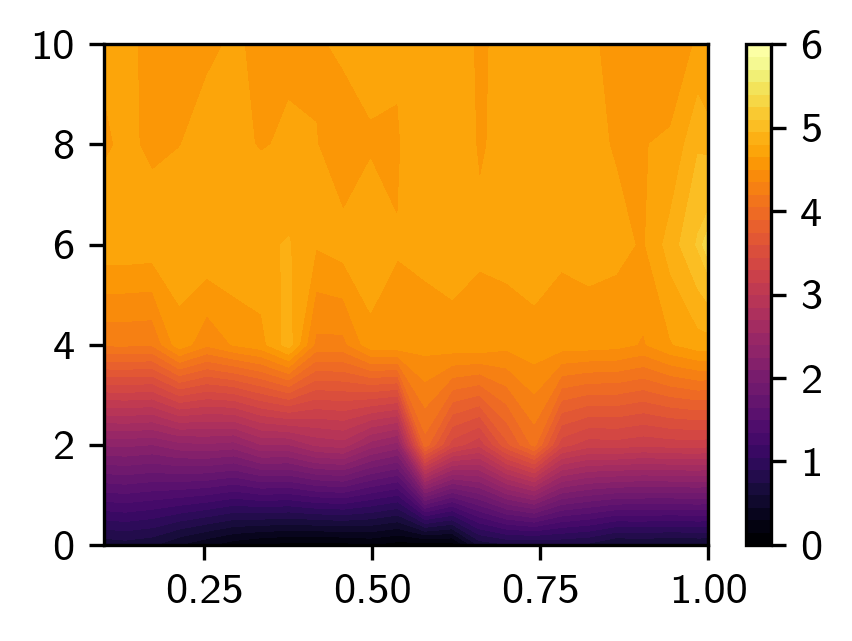

In [172]:
z = cobj.summary['time']
plt.contourf(
    X, Y, np.asarray(z).reshape(np.shape(X)),
    cmap=cm.inferno,
    vmin=min(z),
    vmax=max(z),
    levels=50,
)
plt.colorbar(ticks=[0, 1, 2 , 3, 4, 5, 6])
plt.xlim(0.1, 1)
plt.ylim(0, 10)

(0, 10)

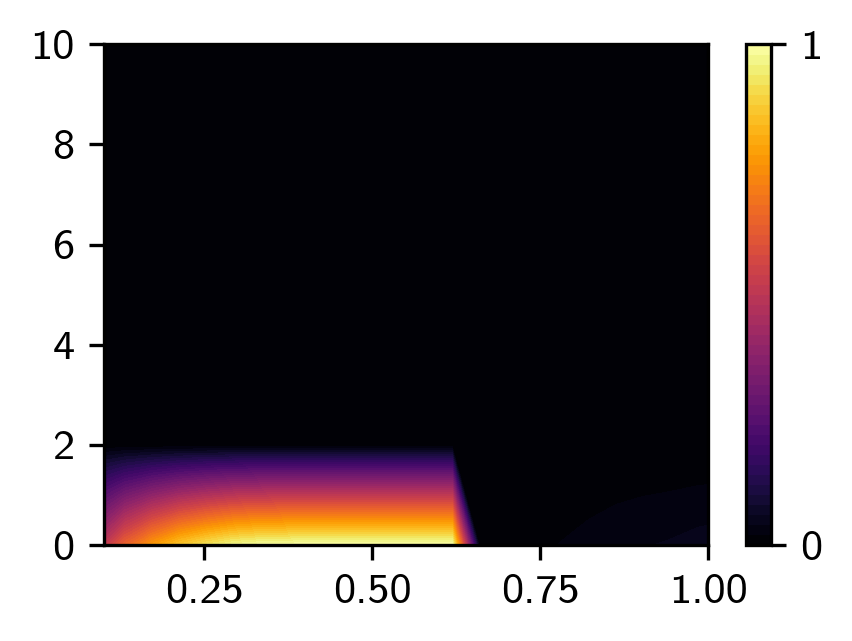

In [171]:
z = cobj.summary['noise']
plt.contourf(
    X, Y, np.asarray(z).reshape(np.shape(X)),
    cmap=cm.inferno,
    vmin=min(z),
    vmax=max(z),
    levels=50,
)
plt.colorbar(ticks=[0, 1, 2 , 3, 4, 5, 6])
plt.xlim(0.1, 1)
plt.ylim(0, 10)

(0, 20)

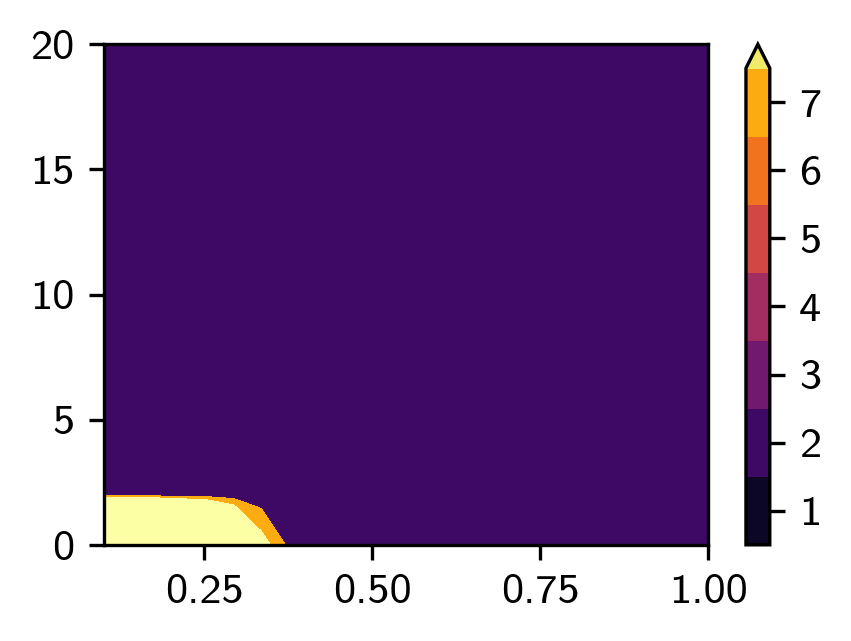

In [170]:
z = cobj.summary['n_clusters']
fig, ax = plt.subplots()
contour = ax.contourf(
    X, Y,
    np.asarray(z).reshape(np.shape(X)),
    cmap=cm.inferno,
    levels=50,
    vmin=1,
    vmax=9,
)
m = plt.cm.ScalarMappable(cmap=cm.inferno,)
m.set_array(np.asarray(z).reshape(np.shape(X)))
m.set_clim(1, 9)
cbar = fig.colorbar(
    m,
    boundaries=np.linspace(1, 9, 9),
    ticks=[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5],
    extend='max'
)
cbar.ax.set_yticklabels([1, 2, 3, 4, 5, 6, 7])
plt.xlim(0.1, 1)
plt.ylim(0, 20)

(0, 10)

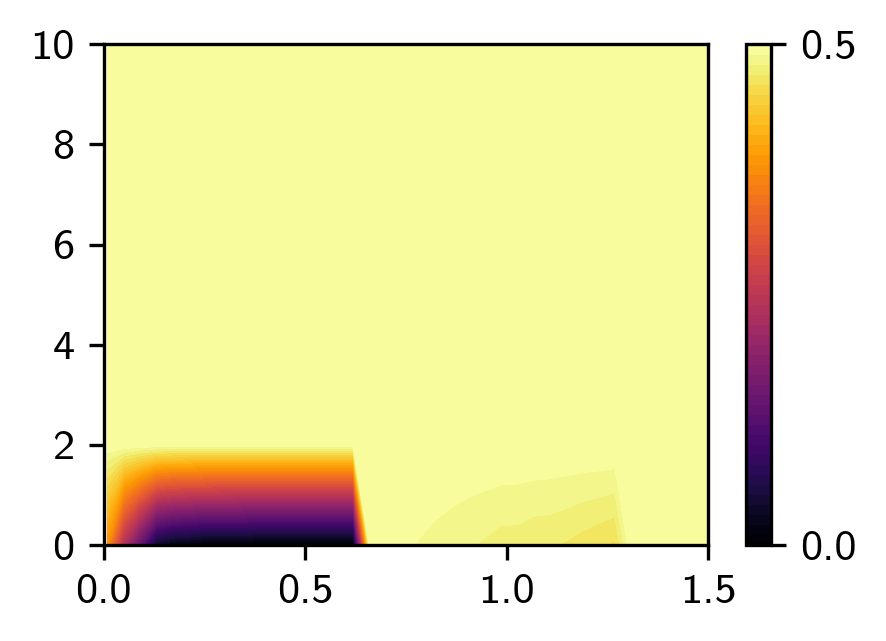

In [152]:
z = cobj.summary['largest']
plt.contourf(
    X, Y, np.asarray(z).reshape(np.shape(X)),
    cmap=cm.inferno,
    vmin=min(z),
    vmax=max(z),
    levels=50,
)
plt.colorbar(ticks=[0, 0.5])
plt.xlim(0, 1.5)
plt.ylim(0, 10)